In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")
    
from preprocess import Preprocessing
df = pd.read_excel("Data.xlsx")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11906 entries, 0 to 11905
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   urls        11906 non-null  object 
 1   rooms       11906 non-null  int64  
 2   sq_m        11906 non-null  float64
 3   floor       11709 non-null  float64
 4   floors_all  11640 non-null  float64
 5   area        11906 non-null  object 
 6   year        11906 non-null  object 
 7   price       11906 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 744.2+ KB


In [3]:
from sklearn.model_selection import train_test_split
df = pd.read_excel("Data.xlsx")

df = df.drop(columns=["urls"])

y = df["price"]
X = df.drop(columns=["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



# Preprocessing
На данный момент я вижу 3 главные проблемы в датасете: <br>
1) area имеет 267 уникальных классов, а не 8 (кол-во районов в Алмате), <br>
2) В столбце year формата string,более того у некоторых объектов в year строка, которая не конвертируется в int(скорее всего пустые строки) <br>
3) Пропуски в floors_all и в floor <br>


## Problem 1 

Мы видим, что area имеет 267 уникальных классов, хотя в Алмате всего 8 районов. Потому что в столбце area у некоторых объектов названия улицы, а не района. Это надо как-то исправлять. Я создам 9-ый класс для фичи area - 'Район9', куда будут входить все объекты с названием улиц в столбце area

In [4]:
len(X_train.area.unique())

267

In [5]:
almaty_areas = ['Ауэзовский', 'Бостандыкский', 'Алмалинский', 'Алатауский', 'Медеуский', 'Наурызбайский', 'Турксибский', 'Жетысуский']
X_train['area'] = X_train['area'].apply(lambda x: x if x in almaty_areas else 'Район9')

In [6]:
X_train['area'].value_counts()

Ауэзовский       2187
Бостандыкский    1924
Алмалинский      1405
Алатауский       1112
Медеуский         999
Наурызбайский     981
Турксибский       966
Жетысуский        858
Район9            283
Name: area, dtype: int64

## Problem 2

У некоторых объектов странные строки, которые не конвертируются в число

In [7]:
try: 
    X_train['year'] = X_train['year'].astype(int)
except ValueError as v:
    print(f'Uppd, I have some probelms with conversion')


Uppd, I have some probelms with conversion


Упс, ошибка значит у нас есть строки, которые нельзя превращать в int. Скорее всего это пустые строки. Проверим:

In [8]:
empty_str_ind = []
for i in X_train.index.values:
    try: 
        X_train['year'][i] = int(X_train['year'][i])
    except:
        print(f'{i}-th element exception, string = {X_train.year[i]}')
        empty_str_ind.append(i)

cnt = len(empty_str_ind) 
print(f'количество строк, которые нельзя конвертировать в число = {cnt}, это {100 * cnt/X_train.shape[0]:.3f} % данных')

7872-th element exception, string =     
9883-th element exception, string =     
3989-th element exception, string =     
1190-th element exception, string =     
3942-th element exception, string =     
2510-th element exception, string =     
6814-th element exception, string =     
4921-th element exception, string =     
6829-th element exception, string =     
10614-th element exception, string =     
9178-th element exception, string =     
5554-th element exception, string =     
7795-th element exception, string =     
11409-th element exception, string =     
8373-th element exception, string =     
4168-th element exception, string =     
8277-th element exception, string =     
11897-th element exception, string =     
2428-th element exception, string =     
5588-th element exception, string =     
количество строк, которые нельзя конвертировать в число = 20, это 0.187 % данных


Да, был прав, это пустые строки и их нельзя конвертировать в int. Впрниципе их очень мало - всего 20. Возможно имеет смысл просто убрать их в training. В тест сете мы будем просто заменять их медианами year по району в трейнинг сет

In [9]:
X_train.drop(empty_str_ind, inplace = True)
y_train.drop(empty_str_ind, inplace = True)
X_train['year'] = X_train['year'].astype(int)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
#X_val.reset_index(drop=True, inplace=True)
#X_test.reset_index(drop=True, inplace=True)

X_train.groupby(['area'])['year'].median().to_dict()

{'Алатауский': 2015,
 'Алмалинский': 1983,
 'Ауэзовский': 1986,
 'Бостандыкский': 1989,
 'Жетысуский': 1990,
 'Медеуский': 2007,
 'Наурызбайский': 2019,
 'Район9': 2014,
 'Турксибский': 1991}

## Пропуски в floors_all и в floor 

В общей сложности в training set у нас 235 пропусков либо у floor либо у floors_all. Как их будем заполнять?

In [10]:
X_train.isna().sum()

rooms           0
sq_m            0
floor         172
floors_all    235
area            0
year            0
dtype: int64

In [11]:
null_data = X_train[X_train.isnull().any(axis=1)]
null_data.shape

(235, 6)

По боксплоту внизу видим, что есть какая-никая зависимость года постройки и количество этажов - раньше строили больше маленьких домов - [1-5] этажных, сейчас больше высоток. Этот факт мы можем использовать чтобы заполнить floors_all - берем медианну по year_div([-1990] years, [1991-2010], [2010-2020]). Floors будем заполнять как 
floors_all //2 - что-то средне, думаю цены на среднех этажах не отличаются.

[Text(0.5, 1.0, 'floors_all vs year')]

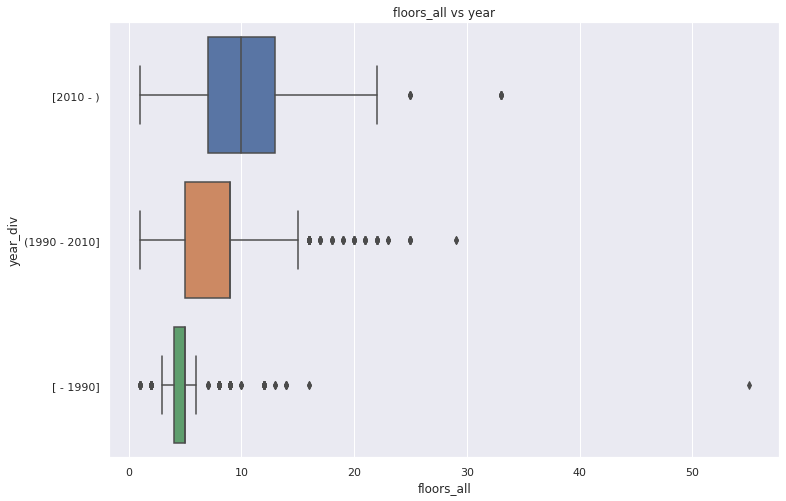

In [12]:
sns.set(rc={'figure.figsize':(12,8)})


year_div = []
for i in range(0, X_train.shape[0]):
    if X_train.iloc[i]['year'] <= 1990: 
        year_div.append('[ - 1990]')
    elif X_train.iloc[i]['year'] > 1990 and X_train.iloc[i]['year'] <= 2010:    
        year_div.append('(1990 - 2010]')
    else:    
        year_div.append('[2010 - )')

X_train['year_div'] = year_div
sns.boxplot(data=X_train, x='floors_all', y='year_div').set(title='floors_all vs year')

Получается запоняем след образом: <br>

1 случае(floor и floors_all NaN): floors_all - медианна по year_div, floor = floors_all//2 <br>
2 случае(только floors_all NaN): floors_all = floors*2 <br>
3 случае(только floor NaN): floors = floors_all // 2<br>

In [13]:
year_median_floor = X_train.groupby('year_div')['floors_all'].median().to_dict()
X_train.drop(columns=['year_div'], inplace=True)

In [14]:
year_median_floor

{'(1990 - 2010]': 9.0, '[ - 1990]': 5.0, '[2010 - )': 10.0}

In [15]:
import math
def find_floor_all(row):
    if row['year'] <= 1990: 
        floors_all = year_median_floor['[ - 1990]']
    elif 1990 < row['year'] <= 2010:    
        floors_all = year_median_floor['(1990 - 2010]']
    else:    
        floors_all = year_median_floor['[2010 - )']
    return floors_all

indices = []
for i in range(0, X_train.shape[0]):
    if math.isnan(X_train.iloc[i]['floors_all']) and math.isnan(X_train.iloc[i]['floor']):
        indices.append(i)
        X_train['floors_all'].iloc[i] = find_floor_all(X_train.iloc[i])
        X_train['floor'].iloc[i] = X_train['floors_all'].iloc[i] // 2 
    elif math.isnan(X_train.iloc[i]['floors_all']) and not math.isnan(X_train.iloc[i]['floor']):
        indices.append(i)
        X_train['floors_all'].iloc[i] = 2 * X_train['floor'].iloc[i]
    elif math.isnan(X_train.iloc[i]['floor']) and not math.isnan(X_train.iloc[i]['floors_all']):
        indices.append(i)
        if X_train['floors_all'].iloc[i] == 1:
            X_train['floors'].iloc[i] = 1
        else:
            X_train['floor'].iloc[i] = X_train['floors_all'].iloc[i] // 2



# One hot Encoder

У нас есть категориальная фича area, и мы будем использовать one_hot_encoder для кодирования. Есть вариант и target mean encoding, но так как у нас колmь-во классов не такой уж и большой,будем использовать one_hot_encoder

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
one_hot = OneHotEncoder(drop='first')

In [18]:
one_hot.fit(X_train['area'][:,None])#.toarray()#.shape#.values()

OneHotEncoder(drop='first')

In [19]:
arr = one_hot.transform(X_train['area'][:,None]).toarray()
df_one = pd.DataFrame(arr, columns = ['area1','area2','area3', 'area4','area5','area6', 'area7', 'area8'])
X_train.drop(columns=['area'], inplace=True)
X_train = pd.concat([X_train, df_one], axis=1)

In [20]:
X_train

,rooms,sq_m,floor,floors_all,year,area1,area2,area3,area4,area5,area6,area7,area8
0,3,78.0,5.0,5.0,2021,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,67.0,3.0,6.0,2009,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,15.0,4.0,5.0,1984,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,75.0,8.0,9.0,2020,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,45.0,4.0,4.0,1967,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10690,3,65.2,5.0,5.0,1993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10691,1,41.0,14.0,14.0,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10692,1,44.3,4.0,5.0,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10693,1,45.0,3.0,9.0,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Normalize

Так как у нас фичи очень разных range, нужно их нормализовать. мы будем делать: <br>

(X- mean)/std. <br>


Получается общий припросессинг выглядит так: <br>

1) Streets_to_area - заменяем название улиц с "Район9" <br>
2) year_to_int - - в трейнинг убираем объяекты с пустым year, в тесте заполнять мединанной year по району в трейнинг сэт <br>
3) missing entries - заполняем пропуски по алгоритму, которую описали выше <br>
4) one_hot_encoder - кодировать area с помощью one_hot_encoder <br>
5) scaler - нормализовать данные<br>

Все эти шаги есть в классе Preprocessing в файле preprocess.py

In [24]:
data = Preprocessing(file_name="Data.xlsx", test_size=0.2, random_state=20)

X_train, X_val, X_test= data.preprocess_data()

In [25]:
X_train.head(2)

,rooms,sq_m,floor,floors_all,year,price,area1,area2,area3,area4,area5,area6,area7,area8
0,1.825058,0.466024,-0.126426,-0.586938,-0.513252,-0.067487,0,0,0,0,0,0,0,0
1,-1.182153,-0.487655,-0.421744,-0.586938,0.943118,-0.548449,0,0,0,0,0,0,0,0


In [26]:
X_test.head(2)

,rooms,sq_m,floor,floors_all,year,price,area1,area2,area3,area4,area5,area6,area7,area8
0,-0.17975,-0.095284,-0.717061,1.016698,-0.319069,0.218489,0,0,1,0,0,0,0,0
1,-0.17975,-0.468582,-0.421744,-0.816029,-0.513252,-0.457456,0,1,0,0,0,0,0,0


In [28]:
X_train.shape, X_val.shape, X_test.shape

((7601, 14), (1905, 14), (2382, 14))

# Data Analysis

In [29]:
X_train = pd.read_csv('./data/train.csv')
y_train = X_train['price']
X_train.drop(columns=['price'], inplace=True)

## Pearson's Correlation of features with target 

Как и ожидали у sq_m и rooms большая корреляция с таргетом

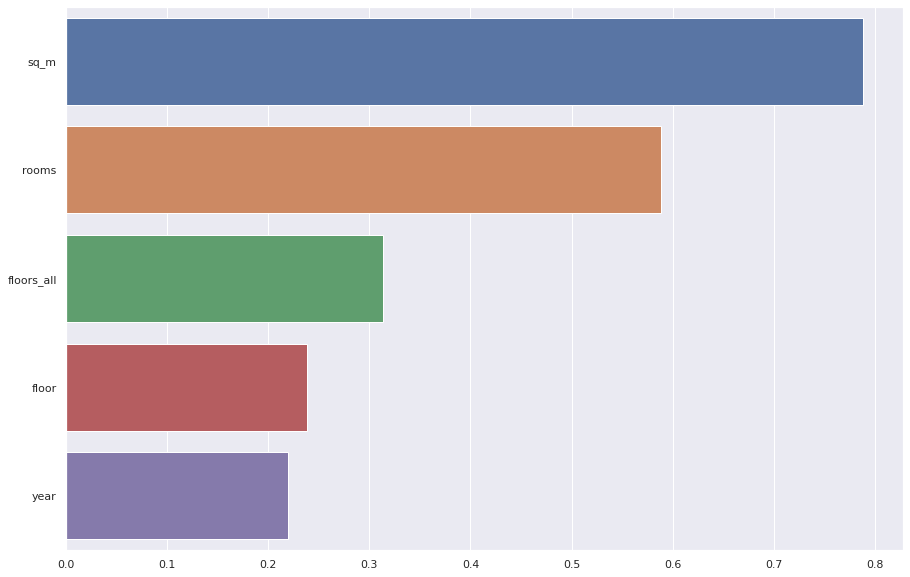

In [30]:
numeric_features = ['rooms', 'sq_m', 'floor', 'floors_all', 'year']
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)


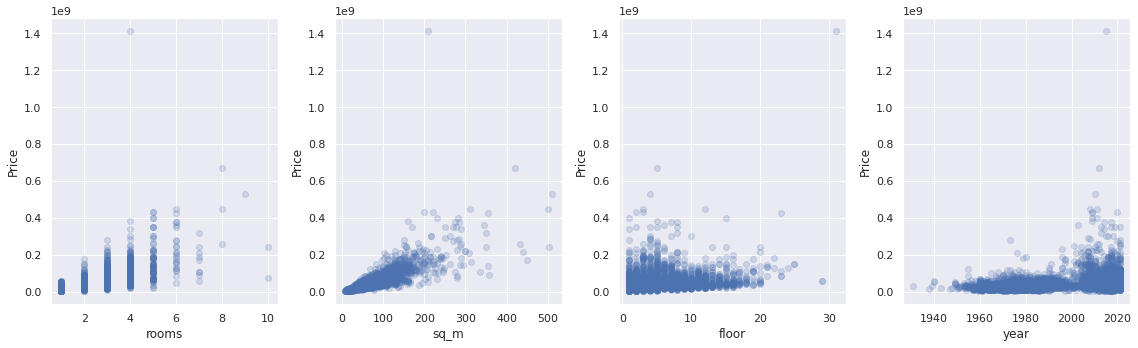

In [31]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=4)
for i, feature in enumerate(["rooms", "sq_m", "floor", "year"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Price")
plt.tight_layout()



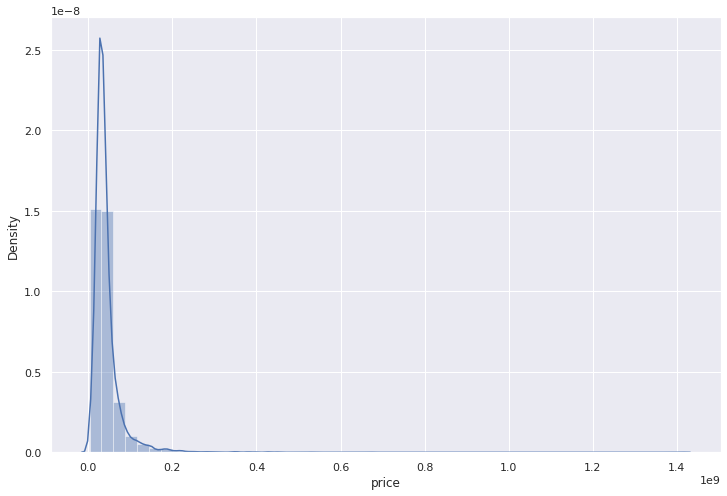

In [32]:
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(y_train)

# Simple Linear model with L2 Regularization

In [17]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle
import numpy as np
import pandas as pd
target_scaler = pickle.load(open('./utils/target_scaler1.pkl','rb'))

#data = Preprocessing(file_name="Data.xlsx", test_size=0.2, random_state=20)#val size = 0.16

alphas = np.logspace(-2, 4, 50)

#X_train, X_val, X_test= data.preprocess_data()
X_train = pd.read_csv('./data/train_norm1.csv')
X_val = pd.read_csv('./data/val_norm1.csv')
X_test = pd.read_csv('./data/test_norm.csv')

y_train = X_train['price']
X_train.drop(columns=['price'], inplace=True)
y_val = X_val['price']
X_val.drop(columns=['price'], inplace=True)
y_test = X_test['price']
X_test.drop(columns=['price'], inplace=True)

best_mean_square = float('inf')
best_alpha = 0
rmse_list = []
rmse_train_list = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_train_pred = model.predict(X_train)
    rmse = mean_squared_error(target_scaler.inverse_transform(y_val[:,None]), target_scaler.inverse_transform(y_pred[:,None]), squared=False)
    rmse_train = mean_squared_error(target_scaler.inverse_transform(y_train[:,None]), target_scaler.inverse_transform(y_train_pred[:,None]), squared=False)
    print(f'alpha = {alpha:.3f}, val rmse: {rmse:.2f}, train_mse = {rmse_train:.2f}')
    rmse_list.append(rmse)
    rmse_train_list.append(rmse_train)
    if rmse < best_mean_square:
        best_alpha = alpha
        best_mean_square = rmse
 

alpha = 0.010, val rmse: 18639073.24, train_mse = 21517282.28
alpha = 0.013, val rmse: 18639073.57, train_mse = 21517282.28
alpha = 0.018, val rmse: 18639074.00, train_mse = 21517282.28
alpha = 0.023, val rmse: 18639074.58, train_mse = 21517282.29
alpha = 0.031, val rmse: 18639075.35, train_mse = 21517282.30
alpha = 0.041, val rmse: 18639076.38, train_mse = 21517282.31
alpha = 0.054, val rmse: 18639077.74, train_mse = 21517282.34
alpha = 0.072, val rmse: 18639079.56, train_mse = 21517282.40
alpha = 0.095, val rmse: 18639082.00, train_mse = 21517282.49
alpha = 0.126, val rmse: 18639085.27, train_mse = 21517282.66
alpha = 0.168, val rmse: 18639089.66, train_mse = 21517282.95
alpha = 0.222, val rmse: 18639095.60, train_mse = 21517283.45
alpha = 0.295, val rmse: 18639103.68, train_mse = 21517284.35
alpha = 0.391, val rmse: 18639114.73, train_mse = 21517285.91
alpha = 0.518, val rmse: 18639129.99, train_mse = 21517288.65
alpha = 0.687, val rmse: 18639151.28, train_mse = 21517293.43
alpha = 

In [18]:
print(f'best_alpha: {best_alpha}, with val rmse = {best_mean_square:.2f}')

best_alpha: 0.01, with val rmse = 18639073.24


Text(0, 0.5, 'Rmse')

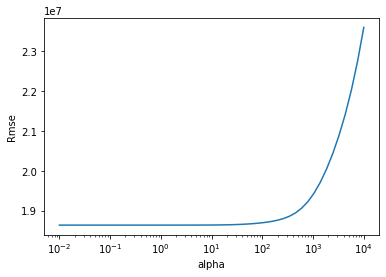

In [19]:
import matplotlib.pyplot as plt
plt.plot(alphas, rmse_list)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Rmse")

In [20]:
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
       
print("Train RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_train[:,None]), target_scaler.inverse_transform(y_train_pred[:,None]), squared=False))
print("Val RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_val[:,None]), target_scaler.inverse_transform(y_val_pred[:,None]), squared=False))
print("Test RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_test[:,None]), target_scaler.inverse_transform(y_pred[:,None]), squared=False))

Train RMSE = 21517282.28
Val RMSE = 18639073.24
Test RMSE = 18603210.51


### So, let's say that 18.6million tenge of rmse in test set is our baseline

In [42]:
#pickle.dump(model, open('./utils/ridge_model.pkl', 'wb'))

In [3]:
#from preprocess import Preprocessing
#import pandas as pd
#data = Preprocessing(file_name="Data.xlsx", test_size=0.1, random_state=30, i = 0)

#X_train, X_val, X_test= data.preprocess_data()

In [82]:
#X_train.shape, X_val.shape, X_test.shape

In [7]:
#X_val.shape[0]/(X_train.shape[0] + X_val.shape[0] + X_test.shape[0])

0.22518281919811717